<img src="../logos/1773_H_Rocket Buds_RK_01_small.jpg" width=200 align=center />

In [1]:
# Load required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import math
import glob
import os
import shutil
import pickle

from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show
output_notebook()

Loading BokehJS ...

In [2]:
# Folder containing measurement files

folder = "../data/thrust_measurements/20211017"

file_list = os.listdir(folder)
file_list.sort()
for file in file_list: print(file)

os.makedirs(os.path.join(folder, "Cleaned"), exist_ok = True)
os.makedirs(os.path.join(folder, "RAW"), exist_ok = True)

2021-09-25_13-20-53.txt
Cleaned
RAW
df_lst.pkl
thrust_graph.html
thrust_measurement_table.csv


1611


<Figure size 1152x648 with 0 Axes>

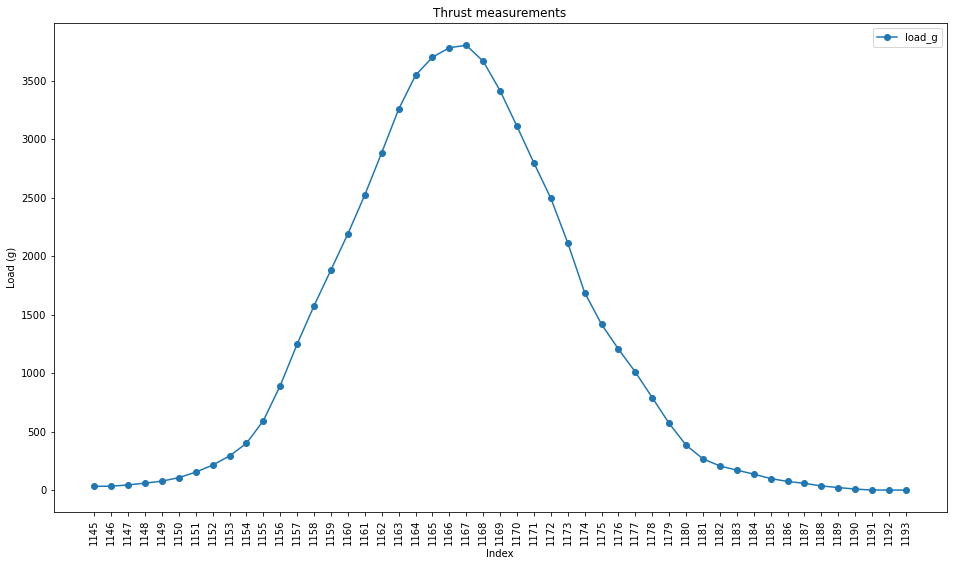

../data/thrust_measurements/20211017/Cleaned/2021-09-25_13-20-53_clean.txt


'../data/thrust_measurements/20211017/RAW/2021-09-25_13-20-53.txt'

In [3]:
# Module for cleaning up measurement files, one by one

file = '2021-09-25_13-20-53.txt'

fig = plt.figure(figsize=(16, 9)) # Prepare plot for populating
df = pd.read_csv(os.path.join(folder, file), sep=r';', engine='python', header=None, names=['time_s','load_g']) # Open each file as timeseries dataframe
df.loc[df.load_g < 0, 'load_g'] = 0 # Replace negative values with zero
print(len(df)) # check number of measurement points

START = 1145
END = 1194#len(df)

#replace outlier in specific point with average of before and after
#point = 77
#df.at[point, 'load_g'] = (df[['load_g']].iloc[point-1] + df[['load_g']].iloc[point+1])/2

df = df.iloc[np.r_[START:END]]
axs = df.reset_index().plot.line(x='index', y="load_g", figsize=(16, 9), title=file, style='o-') # plot measurement points

plt.xticks(range(START,END), rotation=90)
plt.title("Thrust measurements")
plt.xlabel("Index")
plt.ylabel("Load (g)")
plt.show()

csv_name = os.path.join(folder, "Cleaned", file[:-4] + "_clean.txt")
print(csv_name)
df.to_csv(csv_name, sep=r';', index=False, header=False)

shutil.move(os.path.join(folder, file), os.path.join(folder, "RAW", file)) 

In [4]:
# Classify engine based on impulse

def engine_designation(imp_ns, thr_n):
    if imp_ns <= 2.5:
        impulse = "A"
    elif  imp_ns <= 5.0:
        impulse = "B"
    elif  imp_ns <= 10.0:
        impulse = "C"
    elif  imp_ns <= 20.0:
        impulse = "D"
    elif  imp_ns <= 40.0:
        impulse = "E"
    elif  imp_ns <= 80.0:
        impulse = "F"
    elif  imp_ns <= 160.0:
        impulse = "G"
    elif  imp_ns <= 320.0:
        impulse = "H"
    elif  imp_ns <= 640.0:
        impulse = "I"
    elif  imp_ns <= 1280.0:
        impulse = "J"
    elif  imp_ns <= 2560.0:
        impulse = "K"
    elif  imp_ns <= 5120.0:
        impulse = "L"
    elif  imp_ns <= 10240.0:
        impulse = "M"
    elif  imp_ns <= 20480.0:
        impulse = "N"
    elif  imp_ns <= 40960.0:
        impulse = "O"
    elif  imp_ns <= 81920.0:
        impulse = "P"
    elif  imp_ns <= 163840.0:
        impulse = "Q"
    elif  imp_ns <= 327680.0:
        impulse = "R"
    elif  imp_ns <= 655360.0:
        impulse = "S"
    else:
        impulse = "OoB"
    return impulse + str(math.floor(thr_n))

In [5]:
#https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a
    
summary_df = pd.DataFrame(columns = ["filename","Thrust_max_N","Thrust_mean_N","Impulse_Ns","Class"]) # Initialize dataframe
df_lst = []

for filename in sorted(glob.glob(os.path.join(folder, "Cleaned", '*_clean.txt'))):
    df = pd.read_csv(filename, sep=r';', engine='python', header=None, names=['time_s','load_g']) # Open each file as timeseries dataframe
    
    # Data processing
    df['file'] = filename[-29:-4]
    df['thrust_N'] = df['load_g'] / 1000 * 10 # Convert mass grams to kg to N
    df['time_s'] = df['time_s'] - df['time_s'].iloc[0] # Convert all timestamps to relative to recording start
    df.loc[df.thrust_N < 0, 'thrust_N'] = 0 # Replace negative values with zero
    df_lst.append(df)

    summary_df.loc[len(summary_df)] =  {
        "filename": filename[-29:-4], 
        "Thrust_max_N": df.describe()['thrust_N']['max'], 
        "Thrust_mean_N": df.describe()['thrust_N']['mean'], 
        "Impulse_Ns": np.trapz(y=df['thrust_N'], x=df['time_s'])
        }
    summary_df["Class"] = summary_df.apply(lambda x: engine_designation(x.Impulse_Ns, x.Thrust_mean_N), axis=1)

print(summary_df)
summary_df.to_csv(os.path.join(folder, 'thrust_measurement_table.csv'), index=False)

                    filename  Thrust_max_N  Thrust_mean_N  Impulse_Ns Class
0  2021-09-25_13-20-53_clean     38.037571      12.049421    56.09787   F12


In [6]:
with open(os.path.join(folder, 'df_lst.pkl'), 'wb') as f:
    pickle.dump(df_lst, f)

In [7]:
# Plot visualization with Bokeh

def color_gen():
    return (round(np.random.random()*250), round(np.random.random()*250), round(np.random.random()*250))

TOOLS = "pan, wheel_zoom, box_zoom, reset, save, box_select"
p = figure(x_axis_type="auto", tools=TOOLS, width=1280, height=720, 
           title="Thrust (N) vs Time (sec) Plot", x_axis_label='Time (sec)', y_axis_label='Thrust (N)')

for df in df_lst:
    x = df['time_s']
    y = df['thrust_N']
    source = ColumnDataSource(df)
    p.line('time_s', 'thrust_N', source=source, legend_label=df['file'][0], line_width=3, color=color_gen())
    tooltips=[("file", "@file"), ("time_s", "@time_s"), ("thrust_N", "@thrust_N")]
    p.add_tools(HoverTool(tooltips=tooltips))

output_file(os.path.join(folder, 'thrust_graph.html'))
show(p)